In [1]:
import warnings
warnings.filterwarnings('ignore') # For better visibility, warnings are turned off in this notebook

# Industrial Site

In this application of the FINE framework, an energy supply system, consisting of two-regions, is modeled and optimized.

The workflow is structures as follows:
-  Required packages are imported
-  An energy system model instance is created
-  Commodity sources are added to the energy supply system model
-  Commodity conversion components are added to the energy supply system model
-  Commodity storages are added to the energy supply system model
-  Commodity transmission components are added to the energy supply system model
-  Commodity sinks are added to the energy supply system model
-  The energy supply system model is optimized
-  Selected optimization results are presented

# Import required packages

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [2]:
import FINE as fn         # Provides objects and functions to model an energy system 
import pandas as pd       # Used to manage data in tables
import geopandas as gpd   # Used to display geo-referenced plots
import shapely as shp     # Used to generate geometric objects
import numpy as np        # Used to generate random input data

%load_ext autoreload
%autoreload 2

# Model an energy system

## Specify model configuration

In [3]:
doDSM = True

## Create an energy system model instance 

The structure of the energy supply system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_naturalGas_lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [4]:
# Input parameters
locations = {'industry_0'}
commodityUnitDict = {'electricity': r'MW$_{el}$', 'hydrogen': r'MW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen'}
numberOfTimeSteps, hoursPerTimeStep = 52560, 1/6 #8760, 1 
costUnit, lengthUnit = '1e3 Euro', 'km'

# Code
esM = fn.EnergySystemModel(locations=locations, commodities=commodities,
    numberOfTimeSteps=numberOfTimeSteps, commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=hoursPerTimeStep, costUnit=costUnit, lengthUnit=lengthUnit, verboseLogLevel=0)

## Add source component

Source components generate commodities across the energy system's virtual boundaries.

In [5]:
data = pd.read_excel('generationTimeSeries_e825103.xlsx')
operationRateMax = pd.DataFrame(data['e825103_2017_2.3MW_faults9'],index=range(numberOfTimeSteps)) # Dataset with least missing data
operationRateMax.columns = ['industry_0']

In [6]:
# Input parameters
name, commodity ='Wind turbines', 'electricity'
hasCapacityVariable = True
capacityFix = pd.Series([20], index=['industry_0']) # 10 MW_el = 0.01 GW_el
investPerCapacity, opexPerCapacity = 0, 30 # 30 €/kW = 30 1e6€/GW = 30 1e3€/MW
interestRate, economicLifetime = 0.08, 20

# Code
esM.add(fn.Source(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    operationRateMax=operationRateMax, capacityFix=capacityFix, investPerCapacity=investPerCapacity,
    opexPerCapacity=opexPerCapacity, interestRate=interestRate, economicLifetime=economicLifetime))

In [7]:
operationRateMax.sum()

industry_0    12107.056522
dtype: float64

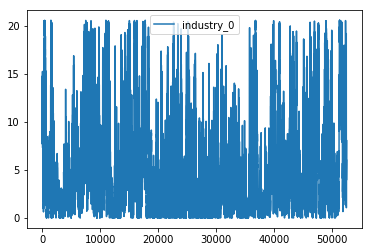

In [8]:
(capacityFix*operationRateMax).plot()

## Add conversion components

In [9]:
esM.add(fn.Conversion(esM=esM, name='PEMEC', physicalUnit=r'MW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.67},
                      hasCapacityVariable=True, 
                      investPerCapacity=2300, opexPerCapacity=12.5, interestRate=0.08, # for 2018 CAPEX
                      economicLifetime=5))

In [10]:
esM.add(fn.Conversion(esM=esM, name='AEC', physicalUnit=r'MW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.64},
                      hasCapacityVariable=True, 
                      investPerCapacity=1300, opexPerCapacity=18, interestRate=0.08, # for 2018 CAPEX
                      economicLifetime=9))

## Add storage components

In [11]:
esM.add(fn.Storage(esM=esM, name='Hydrogen tank (gaseous)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=1,
                   chargeRate=1, dischargeRate=1, sharedPotentialID=None,
                   stateOfChargeMin=0.06, stateOfChargeMax=1,
                   investPerCapacity=0.004, opexPerCapacity=0.004*0.02, interestRate=0.08,
                   economicLifetime=20))

### Industrial hydrogen demand

operationRateFix = pd.DataFrame(2*np.ones(52560)*(1/6), columns=['industry_0']) # constant hydrogen demand of 2 MW_GH2: ATTN
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=operationRateFix))

In [12]:
tDown=1
tUp=2
tDelta = tDown+tUp+1

orf = pd.DataFrame([[i+j for j in range(2)] for i in range(8760)], columns=['A','B'])
orf.head()

,A,B
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5


In [13]:
orf=pd.concat([orf.iloc[-tUp:], orf.iloc[:-tUp]]).reset_index(drop=True)
orf.head()

,A,B
0,8758,8759
1,8759,8760
2,0,1
3,1,2
4,2,3


In [14]:

SOCmax = [[],[],[],[]]
dischargeFix = [[],[],[],[]]
    
for i in range(tDelta):
    SOCmax[i] = pd.concat([orf[orf.index % tDelta == i]]*tDelta).sort_index().reset_index(drop=True)
    SOCmax[i] = pd.concat([SOCmax[i].iloc[tDown+tUp-i:], SOCmax[i].iloc[:tDown+tUp-i]]).reset_index(drop=True)

    dischargeFix[i] = orf.copy()
    dischargeFix[i][dischargeFix[i].index % tDelta != i] = 0

In [15]:
SOCmax[0].tail()

,A,B
8755,8754,8755
8756,8754,8755
8757,8758,8759
8758,8758,8759
8759,8758,8759


In [16]:
dischargeFix[0].tail()

,A,B
8755,0,0
8756,8754,8755
8757,0,0
8758,0,0
8759,0,0


In [17]:
SOCmax[1].tail()

,A,B
8755,8755,8756
8756,8755,8756
8757,8755,8756
8758,8759,8760
8759,8759,8760


In [18]:
dischargeFix[1].tail()

,A,B
8755,0,0
8756,0,0
8757,8755,8756
8758,0,0
8759,0,0


In [19]:
SOCmax[2].tail()

,A,B
8755,8756,8757
8756,8756,8757
8757,8756,8757
8758,8756,8757
8759,0,1


In [20]:
dischargeFix[2].tail()

,A,B
8755,0,0
8756,0,0
8757,0,0
8758,8756,8757
8759,0,0


In [21]:
SOCmax[3].tail()

,A,B
8755,8753,8754
8756,8757,8758
8757,8757,8758
8758,8757,8758
8759,8757,8758


In [22]:
dischargeFix[3].tail()

,A,B
8755,8753,8754
8756,0,0
8757,0,0
8758,0,0
8759,8757,8758


In [23]:
orf.sum()

A    38364420
B    38373180
dtype: int64

In [24]:
pd.DataFrame(2*np.ones(52560)*(1/6), columns=['industry_0']).sum()

industry_0    17520.0
dtype: float64

In [25]:
#operationRateFix = pd.DataFrame(2*np.ones(52560)*(1/6), columns=['industry_0']) # constant hydrogen demand of 2 MW_GH2: ATTN

opFix_ = pd.DataFrame([0, 1, 0.2, 0.1], columns=['industry_0'])
operationRateFix = pd.concat([opFix_ for i in range(13140)]).reset_index(drop=True)

if doDSM:
    esM.add(fn.DemandSideManagement(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                    tUp=2, tDown=1, operationRateFix=operationRateFix))
else:
    esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                    operationRateFix=operationRateFix))

In [26]:
esM.componentNames

{'Wind turbines': 'SourceSinkModel',
 'PEMEC': 'ConversionModel',
 'AEC': 'ConversionModel',
 'Hydrogen tank (gaseous)': 'StorageModel',
 'Hydrogen demand_0': 'StorageExtModel',
 'Hydrogen demand_1': 'StorageExtModel',
 'Hydrogen demand_2': 'StorageExtModel',
 'Hydrogen demand_3': 'StorageExtModel',
 'Hydrogen demand': 'DSMModel'}

In [27]:
operationRateFix.sum()

industry_0    17082.0
dtype: float64

In [28]:
esM.getComponent('Hydrogen demand').fullOperationRateFix.sum()

industry_0    17082.0
dtype: float64

In [29]:
esM.getComponent('Hydrogen demand_0').chargeOpRateFix

In [30]:
esM.getComponent('Hydrogen demand_3').dischargeOpRateFix

# Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [31]:
# Input parameters
numberOfTypicalPeriods=30
numberOfTimeStepsPerPeriod=24*6

# Code
esM.cluster(numberOfTypicalPeriods=numberOfTypicalPeriods,numberOfTimeStepsPerPeriod=numberOfTimeStepsPerPeriod)


Clustering time series data with 30 typical periods and 144 time steps per period...
		(4.2099 sec)



In [32]:
# Input parameters
timeSeriesAggregation=True
solver='gurobi'

# Code
esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)

Time series aggregation specifications:
Number of typical periods:30, number of time steps per periods:144

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2500 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1500 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.6100 sec)

Declaring sets, variables and constraints for StorageExtModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(8.8097 sec)

Declaring sets, variables and constraints for DSMModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1700 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.4700 sec)

Declaring objective function...
		(0.2600 sec)


## Display optimization summaries

For each modeling class, an optimization summary can be stored and displayed. 

#### Source and Sink Component

In [33]:
srcSnkSummary = esM.getOptimizationSummary("SourceSinkModel", outputLevel=1)
display(esM.getOptimizationSummary("SourceSinkModel", outputLevel=2))

industry_0
Component     Property  Unit                      
Wind turbines TAC       [1e3 Euro/a]           600
              capacity  [MW$_{el}$]             20
              operation [MW$_{el}$*h/a]    26690.6
              opexCap   [1e3 Euro/a]           600

#### Conversion Components

In [34]:
convSummary = esM.getOptimizationSummary("ConversionModel", outputLevel=1)
display(esM.getOptimizationSummary("ConversionModel", outputLevel=2))

industry_0
Component Property  Unit                      
AEC       TAC       [1e3 Euro/a]       1231.08
          capacity  [MW$_{el}$]        5.44478
          capexCap  [1e3 Euro/a]       1133.08
          invest    [1e3 Euro]         7078.21
          operation [MW$_{el}$*h/a]    26690.6
          opexCap   [1e3 Euro/a]        98.006

#### Storage Components

In [35]:
storSummary = esM.getOptimizationSummary("StorageModel", outputLevel=1)
display(esM.getOptimizationSummary("StorageModel", outputLevel=2))

industry_0
Component               Property           Unit                             
Hydrogen tank (gaseous) TAC                [1e3 Euro/a]             0.765452
                        capacity           [MW$_{H_{2},LHV}$*h]      1570.45
                        capexCap           [1e3 Euro/a]             0.639816
                        invest             [1e3 Euro]                6.28181
                        operationCharge    [MW$_{H_{2},LHV}$*h/a]    8265.82
                        operationDischarge [MW$_{H_{2},LHV}$*h/a]    8265.82
                        opexCap            [1e3 Euro/a]             0.125636

#### DSM Components

In [36]:
if doDSM:
    DSMSummary = esM.getOptimizationSummary("DSMModel", outputLevel=1)
    display(esM.getOptimizationSummary("DSMModel", outputLevel=2))

,,,industry_0
Component,Property,Unit,
Hydrogen demand,operation,"[MW$_{H_{2},LHV}$*h/a]",17082


In [37]:
if doDSM:
    display(esM.getOptimizationSummary("StorageExtModel", outputLevel=1))    

industry_0
Component         Property           Unit                             
Hydrogen demand_0 TAC                [1e3 Euro/a]                    0
                  operationCharge    [MW$_{H_{2},LHV}$*h/a]       2628
                  operationDischarge [MW$_{H_{2},LHV}$*h/a]       2628
                  opexCharge         [1e3 Euro/a]                    0
                  opexDischarge      [1e3 Euro/a]                    0
Hydrogen demand_1 TAC                [1e3 Euro/a]                    0
                  operationCharge    [MW$_{H_{2},LHV}$*h/a]       1314
                  operationDischarge [MW$_{H_{2},LHV}$*h/a]       1314
                  opexCharge         [1e3 Euro/a]                    0
                  opexDischarge      [1e3 Euro/a]                    0
Hydrogen demand_2 TAC                [1e3 Euro/a]                    0
Hydrogen demand_3 TAC                [1e3 Euro/a]                    0
                  operationCharge    [MW$_{H_{2},LHV}$*h/a]      13140
                  operationDischarge [MW$_{H_{2},LHV}$*h/a]      13140
                  opexCharge         [1e3 Euro/a]                    0
                  opexDischarge      [1e3 Euro/a]                    0

In [38]:
esM.componentModelingDict['StorageExtModel'].dischargeOperationVariablesOptimum #.max(axis=1)

,,0,1,2,3,4,5,6,7,8,9,...,52550,52551,52552,52553,52554,52555,52556,52557,52558,52559
Hydrogen demand_0,industry_0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0
Hydrogen demand_1,industry_0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,...,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0
Hydrogen demand_3,industry_0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [39]:
esM.componentModelingDict['StorageExtModel'].chargeOperationVariablesOptimum #.max(axis=1)

,,0,1,2,3,4,5,6,7,8,9,...,52550,52551,52552,52553,52554,52555,52556,52557,52558,52559
Hydrogen demand_0,industry_0,0.2,0.0,0.0,0.0,0.000000,0.000000,0.200000,0.000000,0.000000,0.2,...,0.2,0.000000,0.0,0.000000,0.0,0.038448,0.000000,0.0,0.161552,0.0
Hydrogen demand_1,industry_0,0.0,0.0,0.0,0.0,0.100000,0.100000,0.000000,0.000000,0.000000,0.1,...,0.1,0.000000,0.0,0.000000,0.0,0.100000,0.000000,0.0,0.000000,0.0
Hydrogen demand_3,industry_0,0.0,0.0,0.0,0.0,0.480776,0.480776,0.380776,0.580776,0.580776,0.0,...,0.0,0.580776,0.0,0.419224,0.0,0.000000,0.580776,0.0,0.419224,0.0


In [41]:
esM.componentModelingDict['StorageExtModel'].stateOfChargeOperationVariablesOptimum #.max(axis=1)

,,0,1,2,3,4,5,6,7,8,9,...,52550,52551,52552,52553,52554,52555,52556,52557,52558,52559
Hydrogen demand_0,industry_0,0.0,0.0,0.0,0.0,0.0,-0.200000,-0.200000,0.000000,0.000000,-0.20000,...,0.0,0.2,0.200000,0.000000,0.0,0.0,0.038448,-0.161552,-0.161552,0.0
Hydrogen demand_1,industry_0,0.0,0.0,-0.1,-0.1,-0.1,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.1,0.100000,0.100000,0.0,0.0,0.100000,0.100000,0.000000,0.0
Hydrogen demand_3,industry_0,0.0,0.0,0.0,0.0,-1.0,-0.519224,-0.038448,0.342328,-0.076896,0.50388,...,1.0,1.0,0.580776,0.580776,1.0,1.0,0.000000,0.580776,0.580776,1.0


## Display regional and operational plots

Plots representing time series can be displayed for each component.

### Wind turbines

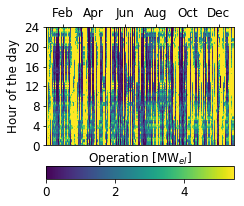

In [42]:
# If wind turbines are built in industry_0, their operation is displayed as heatmap
if srcSnkSummary.loc[('Wind turbines','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Wind turbines', 'industry_0', figsize=(3.5,3), monthlabels=True,
        xlabel='', ylabel='Hour of the day', yticks=range(0,25*6,4*6), yticklabels=range(0,25,4),
        zlabel='', nbTimeStepsPerPeriod=24*6)

### Electrolyzers 

In [43]:
# If PEMECs are built in industry_0 their operation is displayed as heatmap
if convSummary.loc[('PEMEC','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'PEMEC', 'industry_0', figsize=(4,3), 
        monthlabels=True, xlabel='', ylabel='Hour of the day', yticks=range(0,25*6,4*6),
        yticklabels=range(0,25,4), zlabel='Power [MW]', nbTimeStepsPerPeriod=24*6)

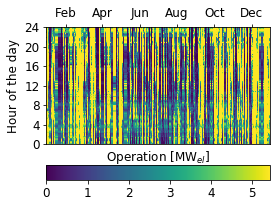

In [44]:
# If AECs are built in industry_0 their operation is displayed as heatmap
if convSummary.loc[('AEC','capacity','[MW$_{el}$]'),'industry_0'] > 0:
    ts = fn.plotOperationColorMap(esM, 'AEC', 'industry_0', figsize=(4,3), monthlabels=True,
        xlabel='', ylabel='Hour of the day', 
        nbTimeStepsPerPeriod=24*6, yticks=range(0,24*6+1,6*4), yticklabels=range(0,25,4))

### Gaseous Hydrogen Tank

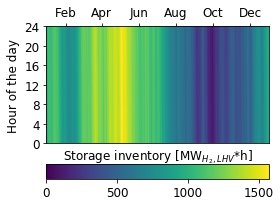

In [45]:
# If Gaseous Hydrogen Tanks are built in industry_0, their storage inventory is displayed as heatmap
if storSummary.loc[('Hydrogen tank (gaseous)','capacity','[MW$_{H_{2},LHV}$*h]'),'industry_0'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Hydrogen tank (gaseous)', 'industry_0', figsize=(4,3),
        variableName='stateOfChargeOperationVariablesOptimum', monthlabels=True,
        xlabel='', ylabel='Hour of the day', yticks=range(0,25*6,4*6), yticklabels=range(0,25,4),
        nbTimeStepsPerPeriod=24*6)

### Hydrogen Demand

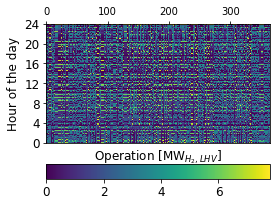

In [46]:
# The hydrogen demand time series in industry_0 is displayed
fig, ax = fn.plotOperationColorMap(esM, 'Hydrogen demand', 'industry_0', figsize=(4,3), 
    yticks=range(0,25*6,4*6), yticklabels=range(0,25,4),
    xlabel='', ylabel='Hour of the day', nbTimeStepsPerPeriod=24*6)